In [37]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from typing import Type, Dict, Any

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import datasets, models, transforms
from sklearn.model_selection import KFold, train_test_split

from matplotlib import colors, pyplot as plt
%matplotlib inline

In [38]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Mar 13 21:43:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:82:00.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |  12719MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [39]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [40]:
with open('df_10types.pkl', 'rb') as f:
      df = pickle.load(f)

In [41]:
# Base 10 types:
ctypes = ['ci', 'cc', 'cs', 'ac', 'as', 'sc', 'st', 'ns', 'cu', 'cb']

In [73]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, df, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = list(df['Full_path'])
        # режим работы
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        self.len_ = len(self.files)
        self.labels = torch.FloatTensor(df[ctypes].values.astype(np.int))
        self.transform = transforms.Compose([transforms.ToTensor()])
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = {
            'val': transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'test': transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'train': transforms.Compose([
                   transforms.ToPILImage(),
                   transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5)),                   
                   transforms.RandomRotation(25),
                   transforms.RandomResizedCrop(244),
                   transforms.RandomHorizontalFlip(0.5),
                   transforms.ToTensor(),
                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        if self.mode == 'test':
            x = transform['test'](x)
            return x
        elif self.mode == 'val':
            x = transform['val'](x)
        else:
            x = transform['train'](x)
        y = self.labels[index]
        return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [96]:
# train_df, val_df = train_test_split(df, test_size=0.2)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)

train_df, val_df = train_test_split(df, test_size=0.25, random_state=1)

In [75]:
train_dataset = SimpsonsDataset(train_df, mode='train')
val_dataset = SimpsonsDataset(val_df, mode='val')
test_dataset = SimpsonsDataset(val_df, mode='test')

In [76]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

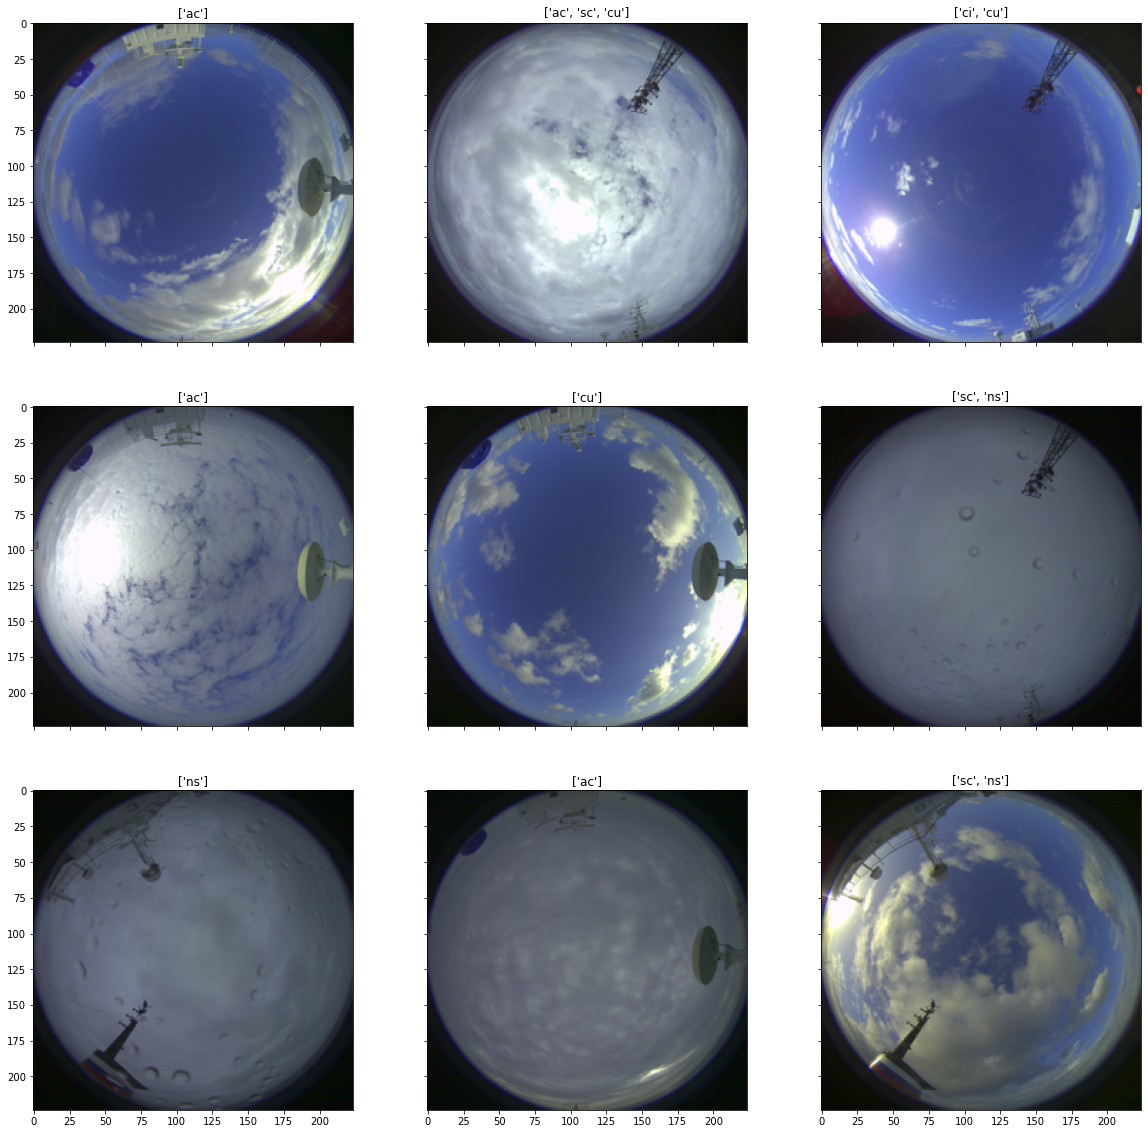

In [77]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(20, 20), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_pics = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_pics]
    img_label = [ctypes[i] for i in range(10) if label[i] == 1]
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

In [78]:
class Ready_model(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [79]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer,
                       loss_function: torch.nn.Module,
                       train_loader: torch.utils.data.DataLoader):
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

In [80]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module,
                          val_loader: torch.utils.data.DataLoader):
    model.eval()
    running_loss = 0.0
    processed_size = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            metrics = calculate_metrics(np.array(outputs.cpu()), np.array(labels.cpu()))
        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    
    
    return {"mean_loss": val_loss, "metrics": metrics}

In [81]:
# Use threshold to define predicted labels and invoke sklearn's metrics with different averaging strategies.
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

In [82]:
def train_model(model: torch.nn.Module,
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module,
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {"momentum": 0.975},
                initial_lr=1e-3,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.StepLR,
                lr_scheduler_params: Dict = {"step_size": 5, "gamma": 0.1},
                batch_size=64,
                max_epochs=10,
                early_stopping_patience=20):
    optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=8)

    best_val_loss = None
    best_epoch = None

    for epoch in range(max_epochs):

        print(f'Epoch {epoch}')
        train_single_epoch(model, optimizer, loss_function, train_loader)
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        metrics = val_metrics['metrics']
        result_loss = val_metrics['mean_loss']
        print("epoch:{:2d}, loss: {:.3f} "
              "micro f1: {:.3f} "
              "macro f1: {:.3f} "
              "samples f1: {:.3f}".format(epoch, result_loss,
                                          metrics['micro/f1'],
                                          metrics['macro/f1'],
                                          metrics['samples/f1']))
        

        lr_scheduler.step()

        if best_val_loss is None or best_val_loss > val_metrics['mean_loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['mean_loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')

        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return

In [83]:
torch.cuda.empty_cache()

In [84]:
if __name__ == "__main__":
    model = Ready_model(len(ctypes))
    # Используем GPU
    model = model.cuda()

    train_model(model,
                train_dataset=train_dataset,
                val_dataset=val_dataset,  
                loss_function=torch.nn.BCELoss(),
                initial_lr=1e-3)

Epoch 0
epoch: 0, loss: 0.296 micro f1: 0.667 macro f1: 0.100 samples f1: 0.667
Best model yet, saving
Epoch 1
epoch: 1, loss: 0.269 micro f1: 0.667 macro f1: 0.100 samples f1: 0.667
Best model yet, saving
Epoch 2
epoch: 2, loss: 0.233 micro f1: 0.500 macro f1: 0.100 samples f1: 0.500
Best model yet, saving
Epoch 3
epoch: 3, loss: 0.220 micro f1: 0.667 macro f1: 0.100 samples f1: 0.667
Best model yet, saving
Epoch 4
epoch: 4, loss: 0.190 micro f1: 0.667 macro f1: 0.100 samples f1: 0.667
Best model yet, saving
Epoch 5
epoch: 5, loss: 0.171 micro f1: 0.667 macro f1: 0.100 samples f1: 0.667
Best model yet, saving
Epoch 6
epoch: 6, loss: 0.165 micro f1: 0.667 macro f1: 0.100 samples f1: 0.667
Best model yet, saving
Epoch 7
epoch: 7, loss: 0.164 micro f1: 1.000 macro f1: 0.200 samples f1: 1.000
Best model yet, saving
Epoch 8
epoch: 8, loss: 0.157 micro f1: 1.000 macro f1: 0.200 samples f1: 1.000
Best model yet, saving
Epoch 9
epoch: 9, loss: 0.154 micro f1: 1.000 macro f1: 0.200 samples f1:

In [94]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            print(inputs)
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [95]:
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=8)
probs = predict(model, val_loader)
probs

[tensor([[[[-2.0152, -2.0152, -1.9467,  ..., -2.0837, -2.0837, -2.0152],
          [-1.9295, -2.0152, -1.9980,  ..., -2.0323, -2.0323, -2.0837],
          [-1.9638, -2.0837, -1.9980,  ..., -2.0494, -2.0837, -2.1008],
          ...,
          [-2.0152, -1.9638, -2.0665,  ..., -2.0665, -2.0837, -1.9980],
          [-2.1008, -2.0494, -2.0152,  ..., -1.9467, -2.0323, -2.1008],
          [-1.9638, -2.0152, -1.9980,  ..., -1.9809, -2.0323, -2.1179]],

         [[-1.8431, -1.8782, -1.8957,  ..., -1.8431, -1.8431, -1.8256],
          [-1.8606, -1.8957, -1.8782,  ..., -1.9132, -1.9132, -1.7731],
          [-1.8782, -1.8782, -1.8782,  ..., -1.9132, -1.9307, -1.7731],
          ...,
          [-1.8606, -1.8957, -1.8081,  ..., -1.8957, -1.9132, -1.8782],
          [-1.7906, -1.8606, -1.8256,  ..., -1.9832, -1.9482, -1.8081],
          [-1.9132, -1.9307, -1.8957,  ..., -1.9482, -1.9657, -1.7906]],

         [[-1.6999, -1.6302, -1.7522,  ..., -1.7347, -1.7696, -1.6824],
          [-1.7870, -1.7347, 

AttributeError: 'list' object has no attribute 'to'

In [97]:
import copy

# сохранить веса нашей нейросети model_C
model_weights = copy.deepcopy(model.state_dict())
torch.save(model_weights, "model_wights.pth")

In [99]:
model.load_state_dict(torch.load("model_wights.pth"))

<All keys matched successfully>

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_ensemble, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]